### 10/31, ここまでの結果について検討してみる
* Stratified-KFoldだと、F1-scoreでCVが0.71を超えたあたりからLBが下がり始める
* そこの境目でCVを組む指針を得られないか

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import torch
import torch.nn as nn

logits = nn.Softmax(dim=1)

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 20000)

* 条件を揃えるために、compare-batchのシリーズを並べてみる

In [27]:
data_path_list = [
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch64/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch32_acc2/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch16_acc4/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch8_acc8/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch4_acc16/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch2_acc32/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch1_acc64/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch32/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch16_acc2/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch8_acc4/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch4_acc8/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch2_acc16/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch1_acc32/",
]

In [28]:
score_df = pd.DataFrame(
    [[0.710,0.683168,0.677548],
    [0.647,0.637636,0.633245],
    [0.663,0.623003,0.610357],
    [0.729,0.670968,0.668412],
    [0.691,0.6304,0.62643],
    [0.666,0.636204,0.6313],
    [0.702,0.627329,0.633061],
    [0.716,0.732919,0.733826],
    [0.720,0.700348,0.695671],
    [0.708,0.664495,0.657493],
    [0.754,0.703125,0.70568,],
    [0.673,0.651828,0.648188],
    [0.708,0.692668,0.691746]],
    columns=["LB", "allCV", "meanCV"]
)

Text(0.2, 0.76, 'LB-meanCV corr: 0.747')

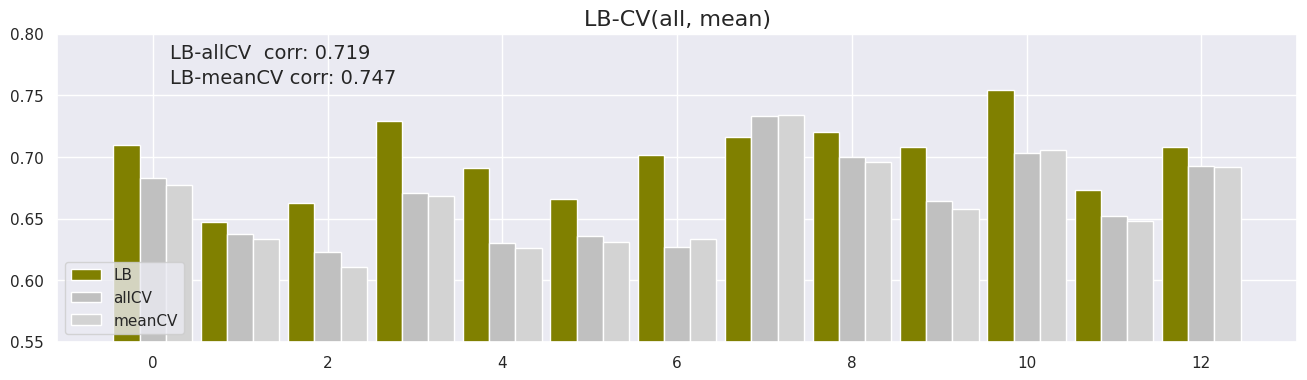

In [29]:
fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(16, 4))

ax.bar(x=score_df.index-0.3, height=score_df.loc[:, "LB"], align="center", width=0.3, color="olive", edgecolor=None, label="LB")
ax.bar(x=score_df.index, height=score_df.loc[:, "allCV"], align="center", width=0.3, color="silver", edgecolor=None, label="allCV")
ax.bar(x=score_df.index+0.3, height=score_df.loc[:, "meanCV"], align="center", width=0.3, color="lightgray", edgecolor=None, label="meanCV")
ax.legend(loc="lower left")
ax.set_title("LB-CV(all, mean)", fontsize=16)
ax.set_ylim([0.55, 0.8])

ax.text(x=0.2, y=0.78, s=f"LB-allCV  corr: {score_df.corr().iat[0, 1]:.3f}", fontsize=14)
ax.text(x=0.2, y=0.76, s=f"LB-meanCV corr: {score_df.corr().iat[0, 2]:.3f}", fontsize=14)

(0.55, 0.8)

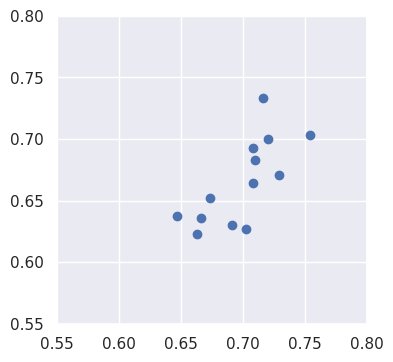

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(score_df["LB"], score_df["allCV"])
ax.set_xlim([0.55, 0.8]); ax.set_ylim([0.55, 0.8])

In [31]:
result_df = []
for i, path in enumerate(data_path_list):
    train_df = pd.read_feather(path+"train_df.feather")
    test_df = pd.read_feather(path+"test_df.feather")

    df = pd.concat([train_df, test_df])

    t = pd.DataFrame(
        logits(torch.Tensor(df.loc[:, ["model_oof_class_0", "model_oof_class_1"]].values)).numpy()[:, 1],
        columns=[f"proba_{i}"]
        )
    result_df.append(t)
result_df = pd.concat(result_df, axis=1).reset_index(drop=True)

In [32]:
result_df = pd.concat(
    [df.loc[:, ["id", "source", "text", "clean_text", "label", "kfold"]].reset_index(drop=True), result_df], 
    axis=1
    )

In [33]:
result_df.head(2)

,id,source,text,clean_text,label,kfold,proba_0,proba_1,proba_2,proba_3,proba_4,proba_5,proba_6,proba_7,proba_8,proba_9,proba_10,proba_11,proba_12
0,80074aa43,news4vip,まともに相手されてない人との関係なんて\nそんな大事にするものか？,まともに 相手 さ れて ない 人 と の 関係 なんて そんな 大事に する もの か ?,0.0,0.0,0.000042,3.789167e-05,0.000001,0.000043,0.000001,0.000003,0.000001,0.000019,0.000048,7.010696e-08,0.000024,3.721301e-07,1.557632e-07
1,6378fea6b,livejupiter,最近はアヘアヘQSマンやない？ ｲｲ!(・∀・)+1-0(・Ａ・)ｲｸﾅｲ!,最近 は アヘアヘ QS マン や ない ? イイ ! ( ・ ∀ ・ ) + 1 - 0 (・A・) イクナイ !,0.0,4.0,0.000005,7.369123e-07,0.000031,0.000006,0.000007,0.000024,0.000007,0.000007,0.000007,5.389698e-06,0.000019,1.274428e-07,1.911447e-06


In [34]:
train_shape = train_df.shape[0]
train_shape

5256

### 予測の数を並べる

In [35]:
for i in range(13):
    result_df[f"model_pred_{i}"] = result_df.loc[:, f"proba_{i}"].map(lambda x: 1 if x>0.5 else 0)

In [36]:
result_df["model_preds_all"] = result_df.iloc[:, 19:].sum(axis=1)

In [50]:
result_train = result_df.loc[:train_shape-1, :]

In [53]:
result_train.groupby("model_preds_all").sum(numeric_only=True)["label"].astype(int)

model_preds_all
0     31
1     10
2     10
3      9
4      7
5     10
6      8
7     16
8     15
9     13
10    16
11    33
12    31
13    97
Name: label, dtype: int64

In [52]:
result_train.groupby("model_preds_all").count()["label"]

model_preds_all
0     4666
1      106
2       48
3       40
4       31
5       34
6       28
7       30
8       31
9       19
10      27
11      46
12      42
13     108
Name: label, dtype: int64

In [59]:
result_train[result_train["model_preds_all"] == 12].loc[:, ["text", "label", "model_preds_all"]]

,text,label,model_preds_all
34,そら女には力はないし頭も男の方が優れてるからな\n女には女の仕事があって、男には男の仕事がある\n\n男に満足な育児はできへんからなその点で男は女に劣ってる,1.0,12
120,何語かも解からんわ\n死ねよウンコ在日アイヌめ\n殺すぞ,1.0,12
291,デメリット有りすぎやんけ\n崩壊したチョン半島から日本に汚れた血がやって来るんやで,1.0,12
418,女は好き嫌いや快不快で人や物事を判断する生き物ですからね,1.0,12
455,キムチ臭ぇチョンが１匹粘着してやがるなｗｗ\n\nったく困った有害外来種だぜｗｗ,1.0,12
550,だよな\nオレが在日なら知った時点で熊にでも身を捧げて自殺してるわ\n\n在日のクソチョンって生きてて恥ずかしくないのかね？,1.0,12
801,黒人の遺伝子を持つお前の方が劣等民族だと思う,1.0,12
932,同性愛とペドフィリアの違いがわかるか？\n同性愛は理解され市民権を得ているが、チョッパリは社会悪、世界のガンなのだ\n貴様らチョッパリは世界中から嫌われている,1.0,12
1016,女に家事をさせるのはいじめじゃない\nボケ防止だ\n家事ができない女は劣化が速い\n男は家事が出来なくても独身以外は劣化が速くならない,1.0,12
1056,朝鮮人の価値観を押し付けるなってw\n日本のシステムが嫌なら、祖国に帰れよな。\n\nキムチ悪いわ。,1.0,12
